# Toxicity - Argument Quality Timeseries Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import re
import shutil

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import scikit_posthocs as sp

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False


In [5]:
df = full_df[~full_df.not_intervened]
df.shape

(56375, 13)

In [6]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [7]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


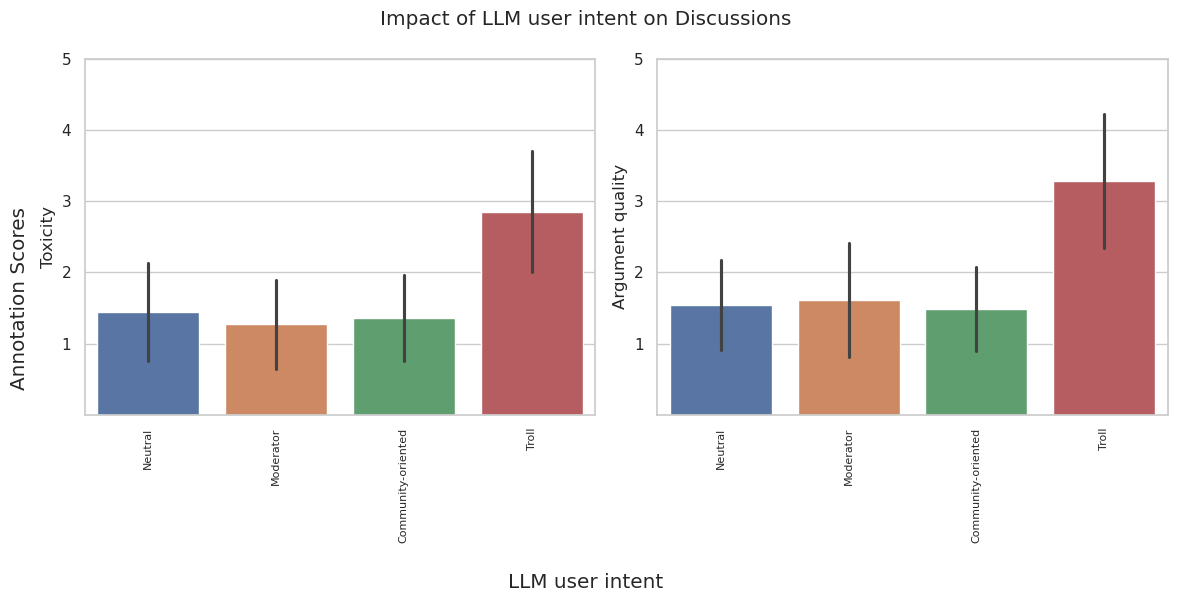

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


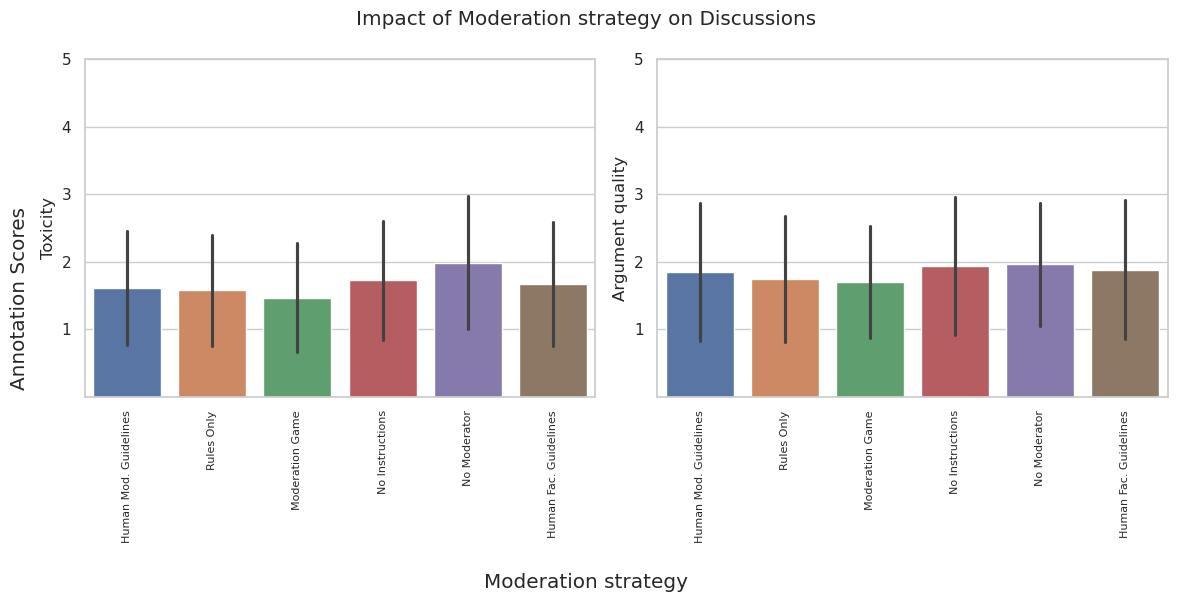

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


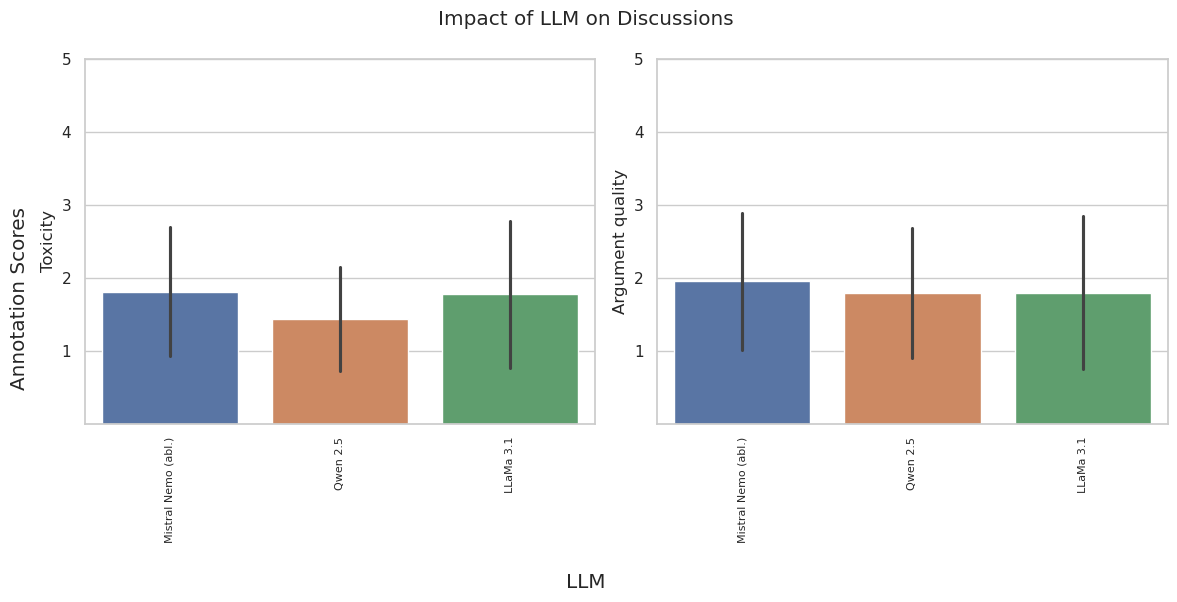

In [10]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Timeseries analysis

### Role

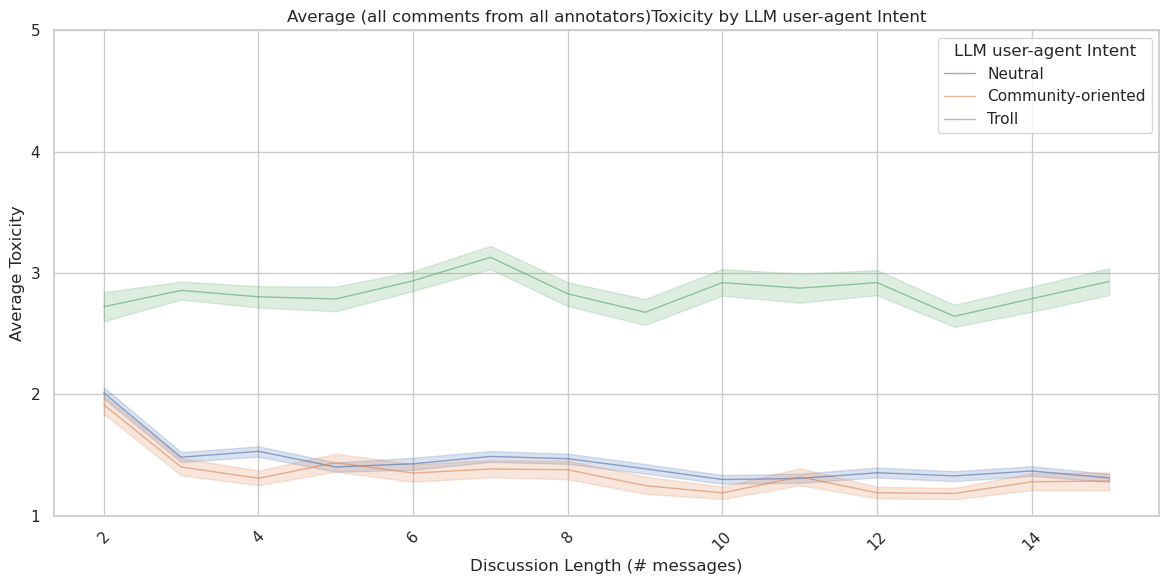

In [11]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

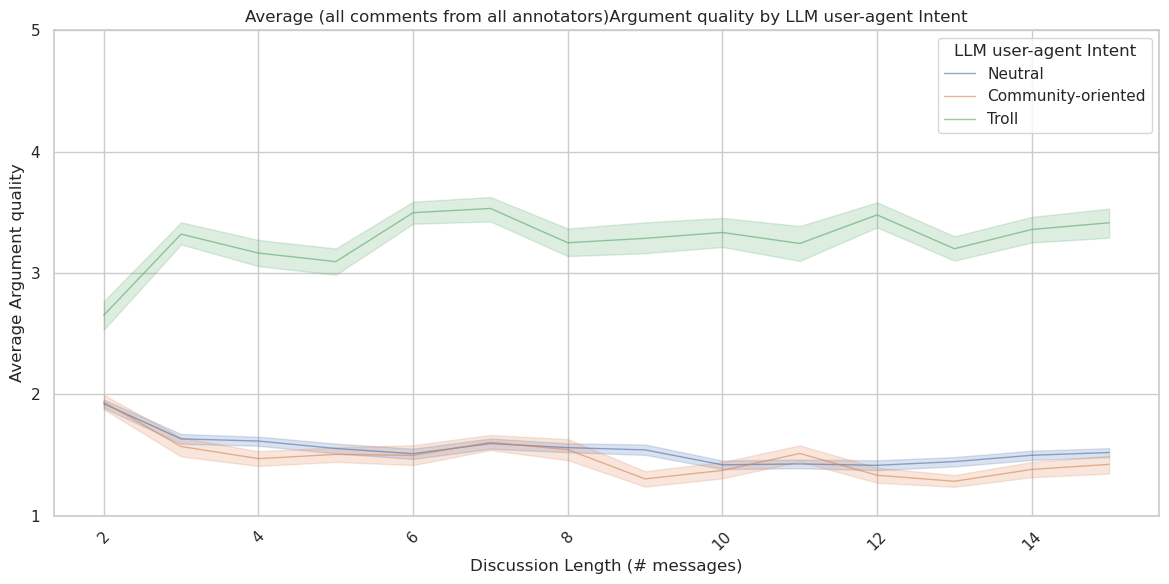

In [12]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy

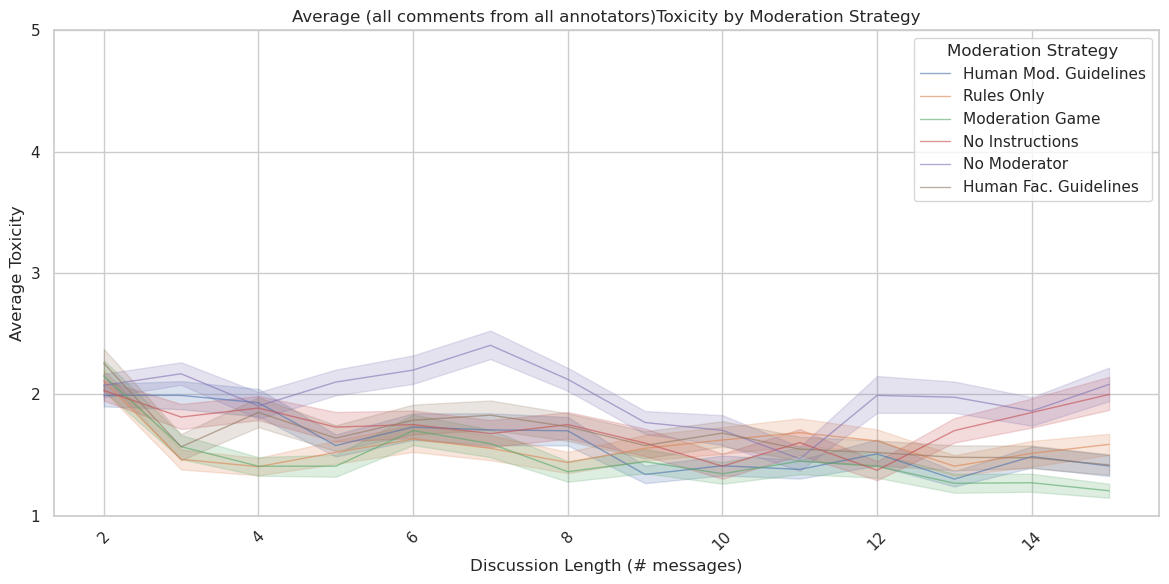

In [13]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

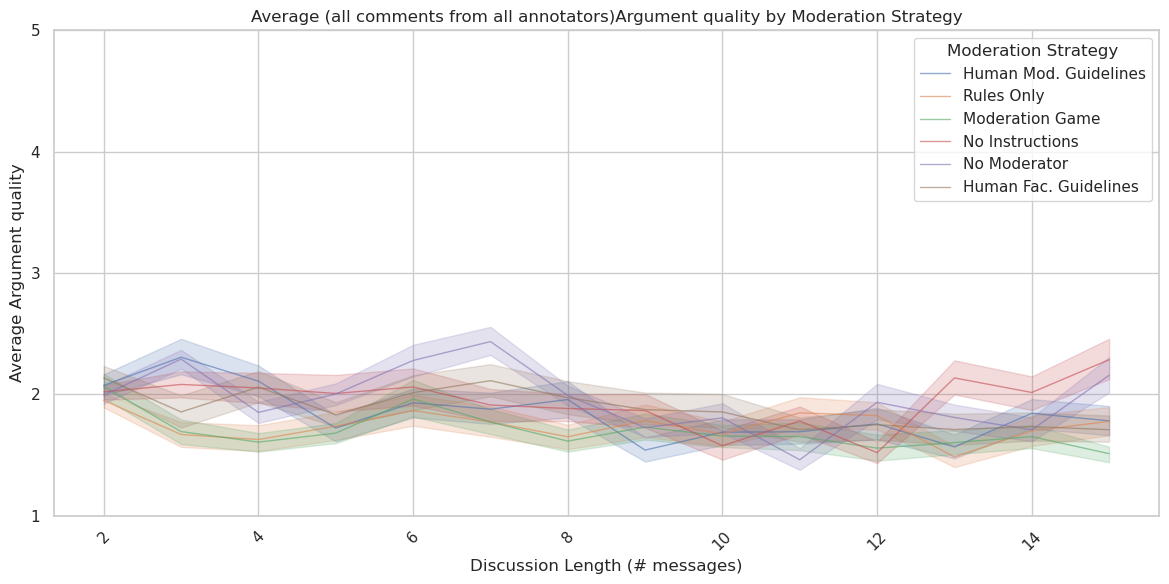

In [14]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Models

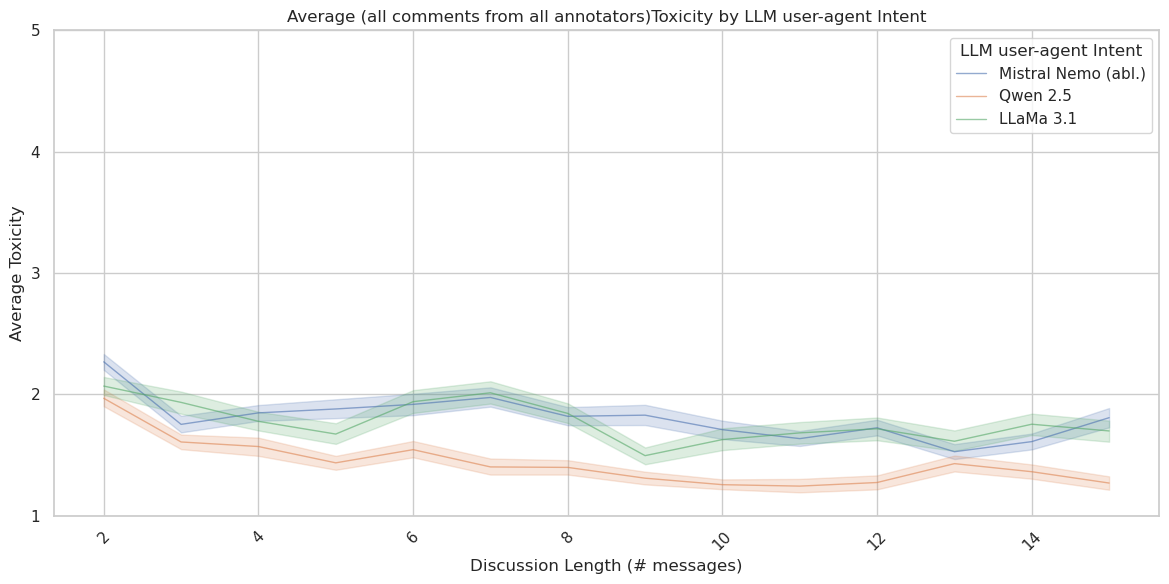

In [15]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

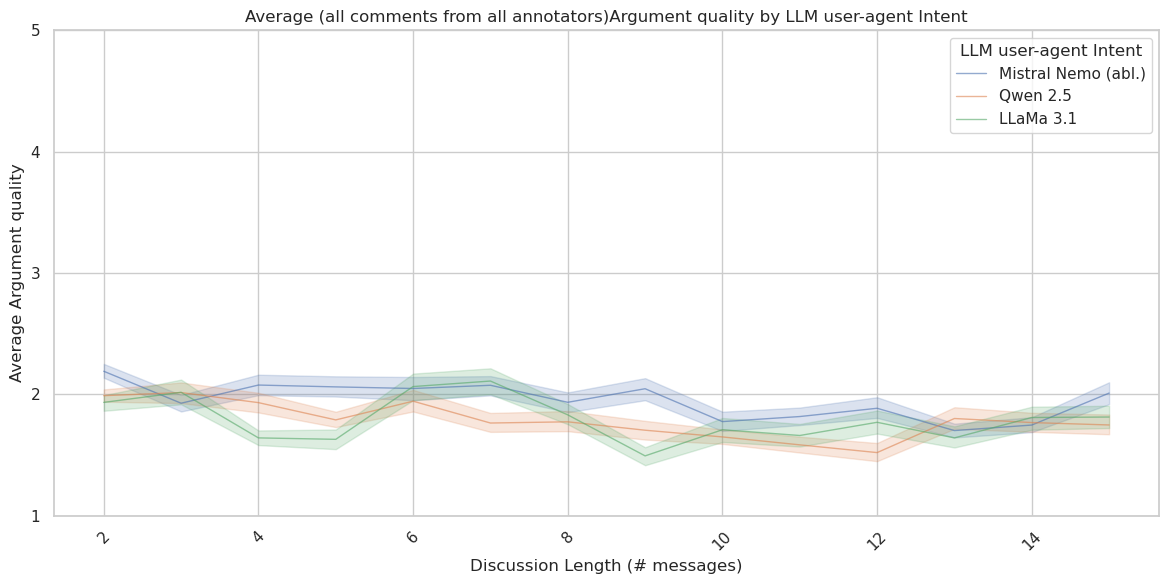

In [16]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

## Statistics

In [17]:
scipy.stats.spearmanr(no_mod_df['message_order'], no_mod_df['Toxicity'])


SignificanceResult(statistic=-0.1584254219439364, pvalue=1.8694030542384473e-120)

In [18]:
model = smf.ols(
    "Toxicity ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Toxicity   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     112.2
Date:                Tue, 15 Apr 2025   Prob (F-statistic):          1.74e-250
Time:                        14:25:26   Log-Likelihood:                -27377.
No. Observations:               21428   AIC:                         5.478e+04
Df Residuals:                   21416   BIC:                         5.487e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       2.1683      0.033     64.939      0.000       2.103       2.234
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]                  -0.1648      0.047     -3.480      0.001      -0.258      -0.072
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]                  -0.1460      0.047     -3.093      0.002      -0.239      -0.053
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]                        -0.3462      0.048     -7.176      0.000      -0.441      -0.252
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                        -0.3248      0.048     -6.721      0.000      -0.420      -0.230
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                             -0.4934      0.047    -10.449      0.000      -0.586      -0.401
message_order                                                                                  -0.0212      0.004     -5.957      0.000      -0.028      -0.014
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]:message_order    -0.0180      0.005     -3.551      0.000      -0.028      -0.008
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]:message_order    -0.0278      0.005     -5.526      0.000      -0.038      -0.018
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]:message_order          -0.0200      0.005     -3.904      0.000      -0.030      -0.010
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order           0.0073      0.005      1.418      0.156      -0.003       0.017
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order                0.0101      0.005      2.011      0.044       0.000       0.020
==============================================================================
Omnibus:                     3166.662   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4750.387
Skew:                           1.123   Prob(JB):                         0.00
Kurtosis:                       3.527   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model = smf.ols(
    "arg_quality ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df.rename({"Argument Quality": "arg_quality"}, axis=1),
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            arg_quality   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     38.99
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           3.40e-84
Time:                        14:25:27   Log-Likelihood:                -29388.
No. Observations:               21428   AIC:                         5.880e+04
Df Residuals:                   21416   BIC:                         5.889e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       2.1772      0.037     59.365      0.000       2.105       2.249
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]                  -0.0531      0.052     -1.021      0.307      -0.155       0.049
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]                  -0.0353      0.052     -0.680      0.496      -0.137       0.066
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]                        -0.2863      0.053     -5.403      0.000      -0.390      -0.182
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                        -0.1832      0.053     -3.452      0.001      -0.287      -0.079
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                             -0.3822      0.052     -7.369      0.000      -0.484      -0.281
message_order                                                                                  -0.0255      0.004     -6.527      0.000      -0.033      -0.018
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Fac. Guidelines]:message_order    -0.0031      0.006     -0.552      0.581      -0.014       0.008
C(conv_variant, Treatment(reference='No Moderator'))[T.Human Mod. Guidelines]:message_order    -0.0092      0.006     -1.667      0.095      -0.020       0.002
C(conv_variant, Treatment(reference='No Moderator'))[T.Moderation Game]:message_order           0.0028      0.006      0.493      0.622      -0.008       0.014
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order           0.0193      0.006      3.407      0.001       0.008       0.030
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order                0.0192      0.006      3.466      0.001       0.008       0.030
==============================================================================
Omnibus:                     3872.273   Durbin-Watson:                   0.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6429.157
Skew:                           1.224   Prob(JB):                         0.00
Kurtosis:                       4.099   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Annotator analysis

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/annotator_variance.png


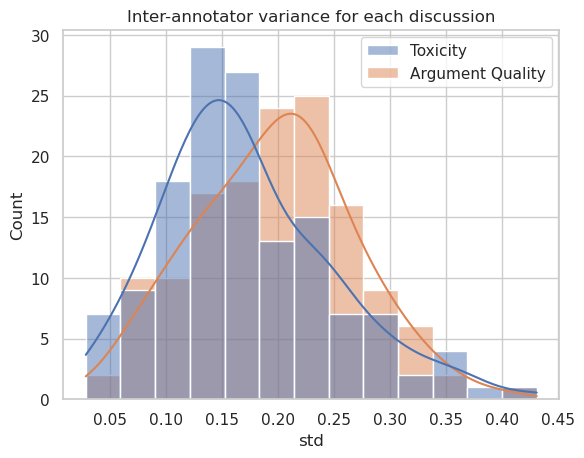

In [20]:
toxicity_var = tasks.stats.discussion_var(
    df, "conv_id", "message_id", "Toxicity"
)
argumentq_var = tasks.stats.discussion_var(
    df, "conv_id", "message_id", "Argument Quality"
)

sns.histplot([toxicity_var, argumentq_var], kde=True)
plt.title("Inter-annotator variance for each discussion")
plt.xlabel("std")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "annotator_variance.png")
plt.show()